In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
gcc (Ubuntu 7.4.0-1ubuntu1~18.04.1) 7.4.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .

# install Pillow 7.0.0 back in order to avoid bug in colab
!pip install Pillow==7.0.0

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 704.4 MB 2.9 kB/s  eta 0:00:01
     |████████████████████████████████| 6.6 MB 28.1 MB/s eta 0:00:01
     |████████████████████████████████| 829 kB 372 kB/s eta 0:00:01
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491058 sha256=a7cad993a3668b5b7f7bb17059bf8b48b4e4ae9718953107cc28e1c4228e4f0f
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: torch
    Found existing installation: torch 1.5.0
    Uninstalling torch-1.5.0:
      Successfully uninstalled torch-1.5.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.6.0a0+82fd1c8
    Uninstalling torchvision-0.6.0a0+82fd1c8:
      Successfully uninstalled torchvision-0.6.0a0+82fd1c8
Cloning into 'mmdetection'...
remote: Enumerating objects: 12, done.
remote: Counting ob

In [1]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.5.1+cu101 True
2.4.0
10.1
GCC 7.3


In [1]:
cd mmdetection

/root/mmdetection


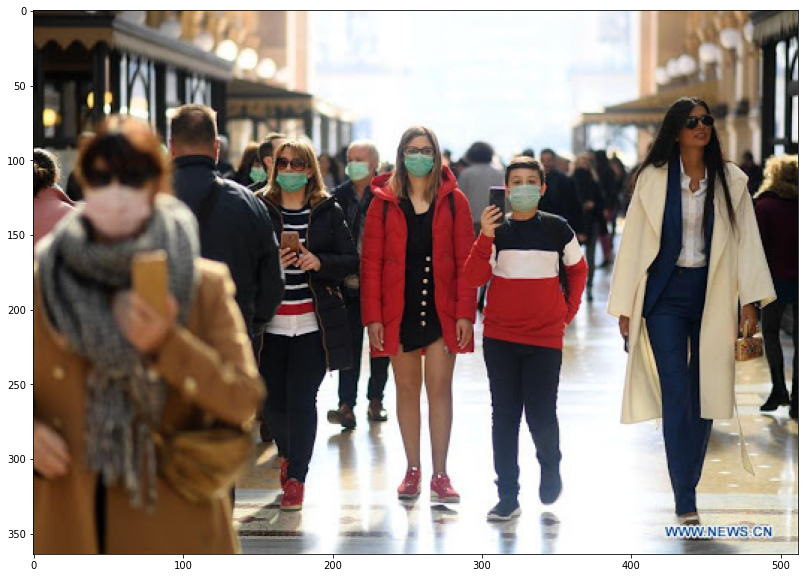

In [2]:
# Let's take a look at the dataset image
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('LabelImg/1unnamed.jpg')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [3]:
import os
import shutil
import json

import random
import copy
import torch
import cv2
import os
import json
import time
import numpy as np
from PIL import Image

from mmcv import Config
import mmcv
from mmdet.apis import inference_detector

from mmcv.runner import init_dist

from mmdet.datasets import build_dataset
from mmdet.models import build_detector

from mmdet import __version__
from mmdet.apis import set_random_seed, train_detector
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.utils import collect_env, get_root_logger

from pycocotools import mask as maskUtils

def main(cfg, seed):
    print('start')
    distributed = False
    validate = None
    timestamp = time.strftime('%Y%m%d_%H%M%S', time.localtime())

    # init logger before other steps
    logger = get_root_logger(cfg.log_level)
    logger.info('Distributed training: {}'.format(distributed))
    logger.info('MMDetection Version: {}'.format(__version__))
    logger.info('Config: {}'.format(cfg.text))

    # set random seeds
    logger.info('Set random seed to {}'.format(seed))
    set_random_seed(seed)
    cfg.seed = seed
    meta = dict()
    meta['seed'] = seed
    
    model = build_detector(
        cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

    datasets = [build_dataset(cfg.data.train)]
    if len(cfg.workflow) == 2:
        datasets.append(build_dataset(cfg.data.val))
    if cfg.checkpoint_config is not None:
        # save mmdet version, config file content and class names in
        # checkpoints as meta data
        cfg.checkpoint_config.meta = dict(
            mmdet_version=__version__,
            config=cfg.text,
            CLASSES=datasets[0].CLASSES)
    # add an attribute for visualization convenience
    model.CLASSES = datasets[0].CLASSES
    train_detector(
        model,
        datasets,
        cfg,
        distributed=distributed,
        validate=validate,
        timestamp=timestamp,
        meta=meta)
    
def generate_rand_color():
    cl = np.random.randint(0, 255, size=(3))
    return (int(cl[0]), int(cl[1]), int(cl[2]))

def visualize_coco_img(coco, img_id, img_dir):
    img_name = [img['file_name'] for img in coco['images'] if img['id'] == img_id][0]
    path_to_img = os.path.join(img_dir, img_name)
    print(path_to_img)
    img = cv2.imread(path_to_img)

    anns = [ann for ann in coco['annotations'] if ann['image_id'] == img_id] #ann[image_id] = ann[id]
    
    cat_colors = {cat['id'] : generate_rand_color() for cat in coco['categories']}
    # plot masks
    for ann in anns:
        segm = ann['segmentation']
        cnt = np.array(segm).reshape(-1,1,2).astype(np.int32)
        cat_id = ann['category_id']
        cat_name = [cat['name'] for cat in coco['categories'] if cat['id'] == cat_id] 
        print(cat_id, cat_name)
        cv2.drawContours(img, [cnt], -1, cat_colors[cat_id], 4)
    return img
   
# In source code in place of image_id = category_id


/root/mmdetection/LabelImg/372084-01-08--Read-Only-_1700583066a_original-ratio.jpg
1 ['Mask']
1 ['Mask']
1 ['Mask']
1 ['Mask']
1 ['Mask']
1 ['Mask']
1 ['Mask']
1 ['Mask']
1 ['Mask']


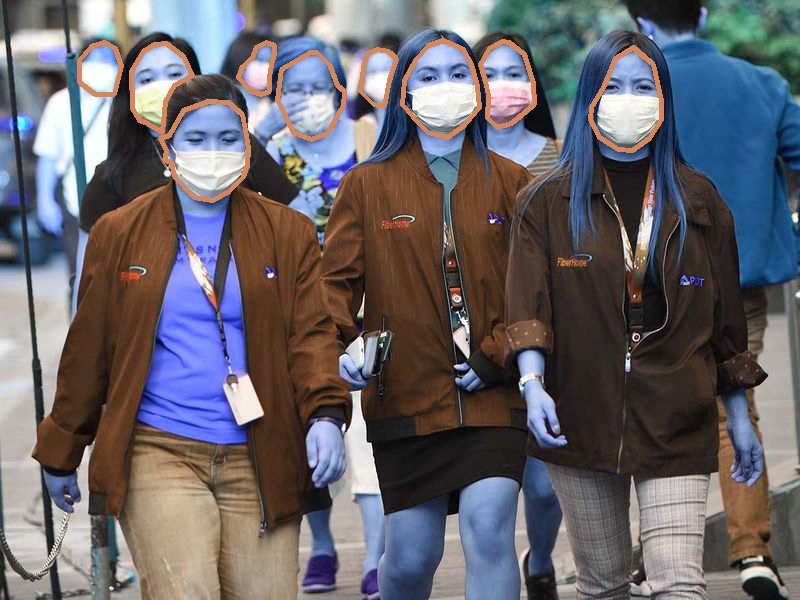

In [70]:
img_dir = 'LabelImg/'
coco_file = open("out.json")
coco = json.load(coco_file)
img = visualize_coco_img(coco, 45, img_dir)
pil = Image.fromarray(img)
pil

In [15]:
coco_name = 'Final_file_Out.json'
path_to_fixed_coco = os.path.join('fixed_out' + coco_name)
with open(path_to_fixed_coco, 'w') as f:
    json.dump(coco, f)

In [10]:
from mmdet.datasets.coco import CocoDataset
from mmdet.datasets.builder import DATASETS

with open(path_to_fixed_coco, 'r') as f:
    coco = json.load(f)
    
# register dataset
clses = tuple(cat['name'] for cat in coco['categories'])
@DATASETS.register_module
class user(CocoDataset):
    CLASSES = clses 

print('label classes are {}'.format(clses))
print('{} images found in {}'.format(len(coco['images']), coco_name))
print('{} annotations found in {}'.format(len(coco['annotations']), coco_name))

label classes are ('Mask', 'No Mask', 'Incorrect')
199 images found in Final_file_Out.json
3710 annotations found in Final_file_Out.json


In [74]:
import mmcv
from mmcv import Config

cfg_file = 'configs/faster_rcnn/faster_rcnn_x101_64x4d_fpn_2x_coco.py' 
cfg = Config.fromfile(cfg_file)


In [17]:
# modify config for training on a single image
cfg.work_dir = "/root/mmdetection"

cfg.data.train.type = 'user'
cfg.data.train.ann_file = path_to_fixed_coco
cfg.data.train.img_prefix = 'LabelImg'

cfg.data.val.type = 'user'
cfg.data.val.ann_file = 'path_to_train_coco '
cfg.data.val.img_prefix = 'LabelImg'

#cfg.data.val.type = ''
#cfg.data.val.ann_file = ''
#cfg.data.val.img_prefix = ''

num_gpus = 1
cfg.gpu_ids = range(num_gpus)
cfg.data.samples_per_gpu = 5 #1
cfg.data.workers_per_gpu = 2
batch_size = cfg.data.samples_per_gpu * num_gpus
cfg.log_config.interval = 1

cfg.total_epochs = 250
cfg.checkpoint_config.interval = cfg.total_epochs
cfg.lr_config.warmup_iters = 3
cfg.lr_config.step = [350, 450]
base_lr = 0.001 / 8  # base learning rate corresponds to that used for training here 
                                # https://github.com/open-mmlab/mmdetection/blob/master/docs/GETTING_STARTED.md
                                # see also linear scaling rule https://arxiv.org/abs/1706.02677
cfg.optimizer.lr = base_lr * batch_size
print('batch size {}, start lr {}'.format(batch_size, cfg.optimizer.lr))

# rescale train image top actual size
#width = coco['images'][0]['width']
#height = coco['images'][0]['height']
scale = (1280, 720) #(width // 2, height //2)
assert max(scale) <= 2**12, 'train image size should be less {}'.format(2**12)
cfg.train_pipeline[2].img_scale = scale
cfg.data.train.pipeline[2].img_scale = scale
print('train image size {}'.format(scale))

batch size 5, start lr 0.000625
train image size (1280, 720)


In [18]:
seed = 41
main(cfg, seed)

2020-10-15 14:31:53,335 - mmdet - INFO - Distributed training: False
2020-10-15 14:31:53,337 - mmdet - INFO - MMDetection Version: 2.4.0
2020-10-15 14:31:53,338 - mmdet - INFO - Config: /root/mmdetection/configs/_base_/models/cascade_mask_rcnn_r50_fpn.py
# model settings
model = dict(
    type='CascadeRCNN',
    pretrained='torchvision://resnet50',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch'),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_co

start


2020-10-15 14:31:54,455 - mmdet - INFO - load model from: open-mmlab://resnext101_64x4d


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


2020-10-15 14:31:56,429 - mmdet - INFO - Start running, host: root@8bc8689c4c01, work_dir: /root/mmdetection
2020-10-15 14:31:56,430 - mmdet - INFO - workflow: [('train', 1)], max: 200 epochs
2020-10-15 14:32:02,430 - mmdet - INFO - Epoch [1][1/40]	lr: 6.250e-07, eta: 13:18:36, time: 5.990, data_time: 2.756, memory: 23589, loss_rpn_cls: 0.6972, loss_rpn_bbox: 0.0814, s0.loss_cls: 4.3912, s0.acc: 0.0000, s0.loss_bbox: 0.0423, s0.loss_mask: 0.8802, s1.loss_cls: 2.4452, s1.acc: 0.0781, s1.loss_bbox: 0.0106, s1.loss_mask: 0.4695, s2.loss_cls: 1.1024, s2.acc: 0.9375, s2.loss_bbox: 0.0018, s2.loss_mask: 0.3838, loss: 10.5056
2020-10-15 14:32:08,367 - mmdet - INFO - Epoch [1][2/40]	lr: 2.087e-04, eta: 13:14:57, time: 5.937, data_time: 0.802, memory: 23589, loss_rpn_cls: 0.7005, loss_rpn_bbox: 0.1813, s0.loss_cls: 4.3845, s0.acc: 0.0781, s0.loss_bbox: 0.0496, s0.loss_mask: 0.7919, s1.loss_cls: 2.4115, s1.acc: 1.1328, s1.loss_bbox: 0.0132, s1.loss_mask: 0.4413, s2.loss_cls: 1.1018, s2.acc: 0.78

In [29]:
from mmdet.models import build_detector
from mmdet.apis import inference_detector, init_detector

config_fname = 'configs/cascade_rcnn/cascade_mask_rcnn_x101_64x4d_fpn_20e_coco.py'
checkpoint_file = 'epoch_200.pth'


model = init_detector(config_fname, checkpoint_file)

In [30]:
def show_result(img,
                result,
                class_names,
                score_thr=0.3,
                wait_time=0,
                out_file=None):
    """Visualize the detection results on the image.
    Args:
        img (str or np.ndarray): Image filename or loaded image.
        result (tuple[list] or list): The detection result, can be either
            (bbox, segm) or just bbox.
        class_names (list[str] or tuple[str]): A list of class names.
        score_thr (float): The threshold to visualize the bboxes and masks.
        wait_time (int): Value of waitKey param.
        show (bool, optional): Whether to show the image with opencv or not.
        out_file (str, optional): If specified, the visualization result will
            be written to the out file instead of shown in a window.
    Returns:
        np.ndarray or None: If neither `show` nor `out_file` is specified, the
            visualized image is returned, otherwise None is returned.
    """
    assert isinstance(class_names, (tuple, list))
    img = mmcv.imread(img)
    img = img.copy()
    if isinstance(result, tuple):
        bbox_result, segm_result = result
    else:
        bbox_result, segm_result = result, None
    bboxes = np.vstack(bbox_result)
    # draw segmentation masks
    if segm_result is not None:
        segms = mmcv.concat_list(segm_result)
        inds = np.where(bboxes[:, -1] > score_thr)[0]
        for i in inds:
            color_mask = np.random.randint(0, 256, (1, 3), dtype=np.uint8)
            mask = segms[i]
            img[mask] = img[mask] * 0.5 + color_mask * 0.5
    # draw bounding boxes
    labels = [
        np.full(bbox.shape[0], i, dtype=np.int32)
        for i, bbox in enumerate(bbox_result)
    ]
    labels = np.concatenate(labels)
    mmcv.imshow_det_bboxes(
        img,
        bboxes,
        labels,
        class_names=class_names,
        score_thr=score_thr,
        show=False,
        wait_time=wait_time,
        out_file=out_file)
    if not out_file:
        return img

def get_bboxes(bbox_result, clses):
    bboxes = {}
    for res, cls in zip(bbox_result, clses):
        if res.shape[0] > 0:
            cls_bboxes = [list(bbox[:4].astype(np.int32)) + [bbox[4]] for bbox in res]
            bboxes[cls] = cls_bboxes
            
    return bboxes
        
def show_bboxes(img, bboxes, color):
    
    fig,ax = plt.subplots(figsize=(20, 10))
    # Display the image
    ax.imshow(img)
    
    for bbox in bboxes:
        left = bbox[0]
        top = bbox[1]
        right = bbox[2]
        down = bbox[3]
        width = right - left
        height = down - top

        # Create a Rectangle patch
        rect = patches.Rectangle((left,top),width,height,linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

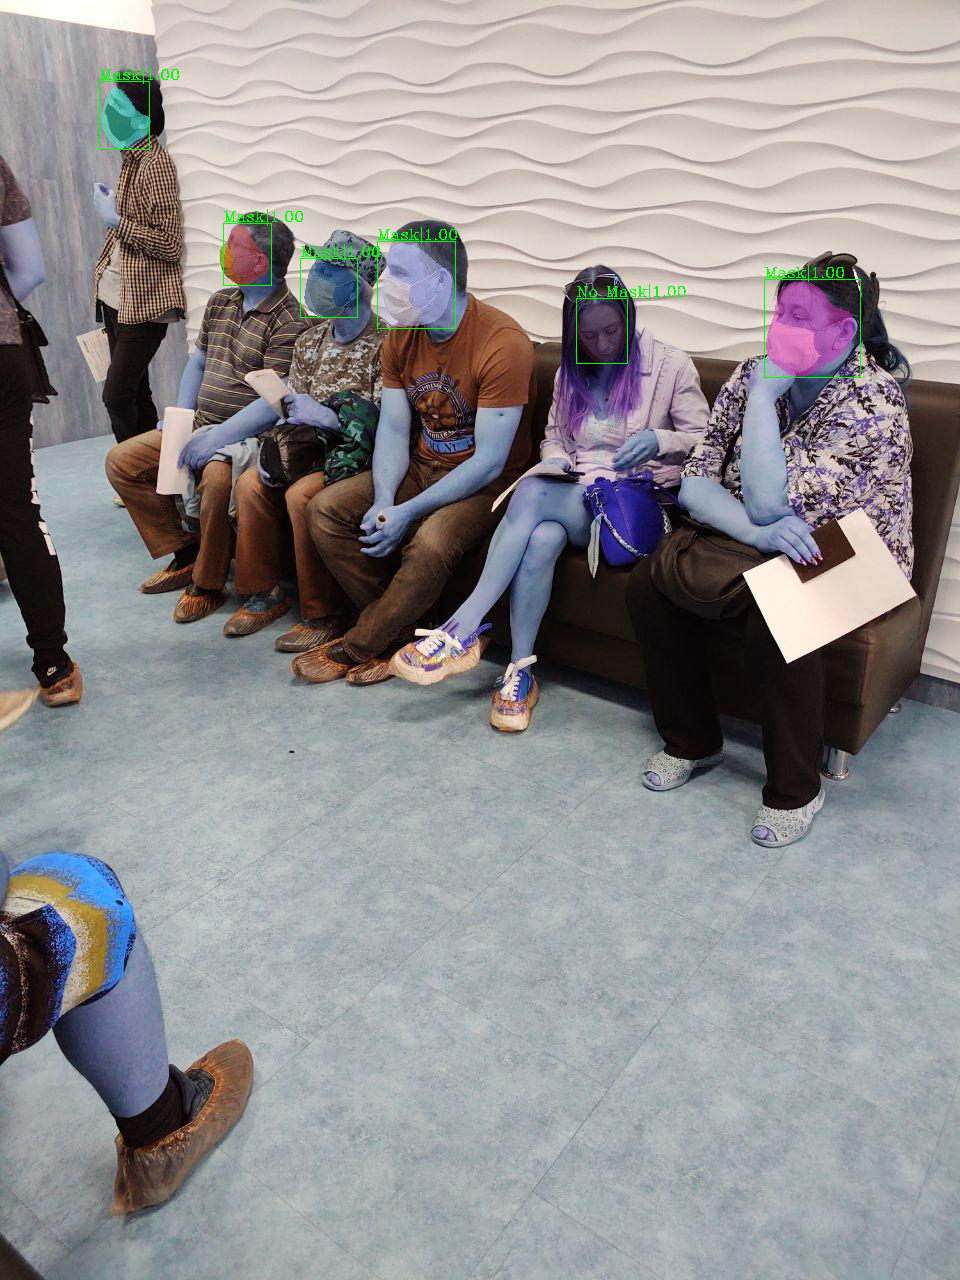

In [54]:
img = '/root/Check/Check_2.jpg'
img = mmcv.imread(img)
img = img.copy()

result = inference_detector(model, img)


img_masked = show_result(img,
                result,
                model.CLASSES,
                score_thr=0.85,
                wait_time=0,
                out_file=None)

pil = Image.fromarray(img_masked)
pil

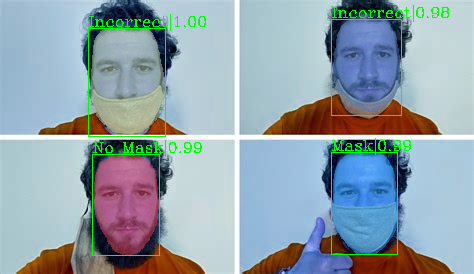

In [65]:
img = '/root/Check/check_13.jpeg'
img = mmcv.imread(img)
img = img.copy()

result = inference_detector(model, img)


img_masked = show_result(img,
                result,
                model.CLASSES,
                score_thr=0.85,
                wait_time=0,
                out_file=None)

pil = Image.fromarray(img_masked)
pil

In [42]:
from time import time
from ttutils import get_pred_coco_for_mAP_caculation
import pycocotools.mask as maskUtils

def get_preds(model, coco, img_dir):
    """"""
    images = coco['images']
    image_files = [image['file_name'] for image in images] 
    imgs = []
    imgs_bboxes = []
    imgs_cnts = []
    imgs_scores = []
    imgs_areas = []
    for image_file in image_files:
        loop_start = time()
        image_path = os.path.join(img_dir, image_file)
        img = mmcv.imread(image_path)
        result = inference_detector(model, img)
        bboxes, segms = result
        inf_time = time() - loop_start
        print('image {} inferenced for {}'.format(image_file, inf_time))
        
        inst_cls = 0
        inds = np.where(bboxes[inst_cls][:,-1] > 0.0001)[0]
        cnts = []
        bbs = []
        areas = []
        for i in inds:
            blank = np.zeros(img.shape[:2])
            mask = segms[inst_cls][i]
            blank[mask] = 1
            areas.append(np.sum(blank))
            cnt, _ = cv2.findContours(blank.astype(np.uint8), cv2.RETR_TREE,
                                   cv2.CHAIN_APPROX_NONE)
            cnts.append(cnt[0])
            bbs.append(bboxes[inst_cls][i])
                        
        imgs.append(img)
        imgs_bboxes.append(bbs)
        imgs_cnts.append(cnts)
        imgs_areas.append(areas)
    
    return image_files, imgs_cnts, imgs_bboxes, imgs_areas



image_files, imgs_cnts, imgs_bboxes, imgs_areas = get_preds(model, coco, img_dir)
coco_pred = get_pred_coco_for_mAP_caculation(image_files, imgs_cnts, imgs_bboxes, imgs_areas, coco)

coco_pred_file = path_to_fixed_coco.split('.')[0] + '_pred_2.json'
coco_pred_path = os.path.join(os.getcwd(), coco_pred_file)

with open(coco_pred_path, 'w') as f:
    json.dump(coco_pred, f)
    

image /root/mmdetection/LabelImg/72e82ddcdd68419cbf72e11937213a7a_8.jpg inferenced for 0.2391831874847412
image /root/mmdetection/LabelImg/af23b165b8b343bc9d1cf56bbe88b19e_18.jpg inferenced for 0.19170403480529785
image /root/mmdetection/LabelImg/OCR-L-SBVIRUSMASKS-0413-1.jpg inferenced for 0.2926604747772217
image /root/mmdetection/LabelImg/download (28).jpeg inferenced for 0.14930057525634766
image /root/mmdetection/LabelImg/freepressjournal_2020-03_a5385171-809e-4376-968a-61ebd4c46dca_PTI16_03_2020_000093B.jpg inferenced for 0.19043397903442383
image /root/mmdetection/LabelImg/c1_1849009_200202191649.jpg inferenced for 0.24329876899719238
image /root/mmdetection/LabelImg/india-kerala.jpg inferenced for 0.16100001335144043
image /root/mmdetection/LabelImg/download (9).jpeg inferenced for 0.11420989036560059
image /root/mmdetection/LabelImg/CANIRRIIR.jpg inferenced for 0.16591310501098633
image /root/mmdetection/LabelImg/GettyImages-1199655440.jpg inferenced for 0.21684527397155762
im

In [73]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

cocoGt= COCO(path_to_fixed_coco)
cocoDt= COCO(coco_pred_path)
imgIds=sorted(cocoGt.getImgIds())
maxDets = [100, 700, 1000]

annType = 'bbox' #either of ['segm','bbox','keypoints']
cocoEval = COCOeval(cocoGt,cocoDt,annType)
cocoEval.params.imgIds  = imgIds
#cocoEval.params.areaRng = [[0, 218], [0, 26], [26, 212], [212, 218]]
cocoEval.params.maxDets = maxDets
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.17s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.04s).
Accumulating evaluation results...
DONE (t=0.05s).
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.215
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.289
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.252
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = -1.000
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = -1.000
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.225
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.228
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=700 ] = 0.228
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets